# Packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import matplotlib as mpl
from qutip import *
from scipy.constants import h,e,k
from scipy.spatial import distance
from matplotlib.ticker import MaxNLocator

phi0 = h/(2*e)
hbar = h/(2*np.pi)

In [21]:
mpl.rcParams['figure.figsize'] = (6, 5)

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['xtick.major.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 1.5
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['xtick.minor.visible'] = True*0
mpl.rcParams['xtick.top'] = True*0

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 1.5
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.minor.visible'] = True*0
mpl.rcParams['ytick.right'] = True*0

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['grid.linewidth'] = 0.01
mpl.rcParams['lines.linewidth'] = 1.5

mpl.rcParams['legend.frameon'] = False

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.05

mpl.rcParams['font.serif'] = ['Times New Roman', 'Computer Modern Serif', 'DejaVu Serif']
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'

mpl.rcParams['axes.labelweight'] = 'bold'  
mpl.rcParams['xtick.labelsize'] = 12  
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams['axes.labelsize'] = 14  


# Photon source 

Consider an artificial two level system of frequency $\omega_s$ coupled to a cavity of frequency $\omega_r = \omega_s$ with a coupling strength $g_{eff}$ which can be tuned through an external flux $\Phi_c$. We suppose that the artifical two level system is manipulated to have a transition rate from the ground state to the excited state of $\Gamma$ much larger than its decaying rate $\gamma$ and that the cavity has a loss rate of $\kappa$. We study the system with QuTip for different coupling strength $g_{eff}$ using the following Jaynes-Cummings hamiltonian to model its dynamics: 

$H = \hbar \omega_s a^{\dagger} a + \hbar \omega_s \sigma_z/ 2 + g_{eff} (a^{\dagger} \sigma^- + a \sigma^+)$

We model the transition rates in the system through the collapsing operators:


$C_{\sigma^+} = \sqrt{\Gamma} \sigma^+$

$C_{\sigma^-} = \sqrt{\gamma} \sigma^-$

$C_{a} = \sqrt{\kappa (1+n_{th})} a$

$C_{a^{\dagger}} = \sqrt{\kappa n_{th}} a^{\dagger}$

where $n_{th}$ defines the thermal photons inside the resonator

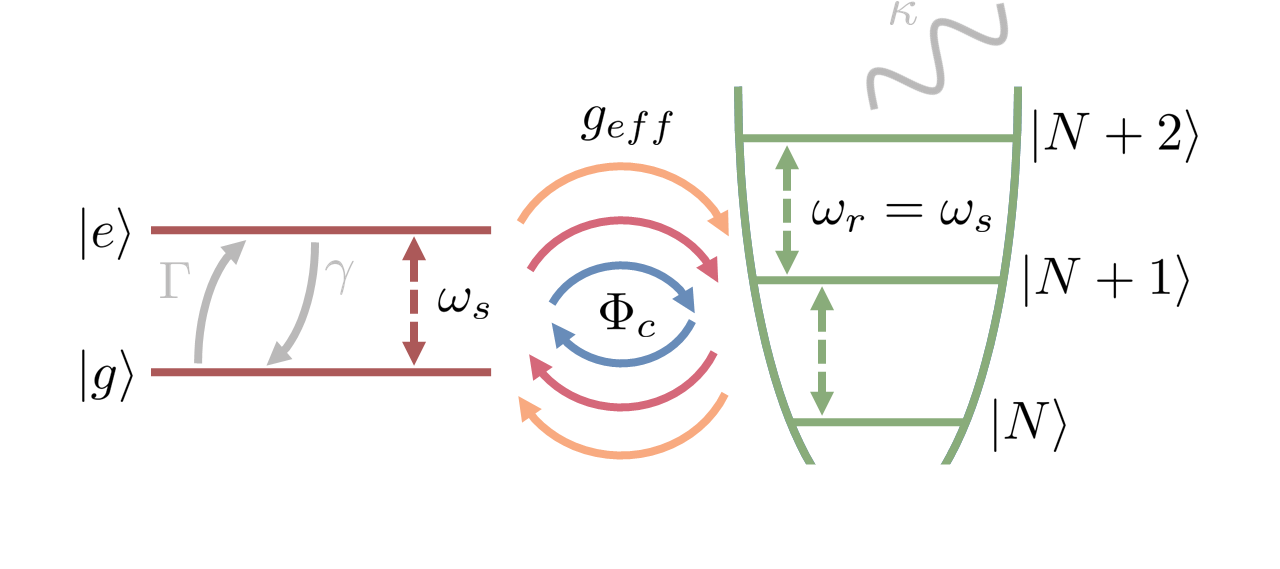

In [2]:
#! frequency unit: GHz!#

### frequencies

ws = 5.0  * 2 * np.pi # cavity resonance frequency
wr = ws  # two level system transition frequency
geff  = 0.05 * 2 * np.pi  # coupling strength 

### transition rates

kappa = 1e-4 # cavity loss rate
gamma = 0. # two level system decaying rate
Gamma = 1e-2 # two level system pump rate
n_th_a = 0.0 # thermal reservoir excitations

In [3]:
### operators

N = 50 # Hilbert space dimension

a  = tensor(destroy(N), qeye(2)) # cavity mode
sm = tensor(qeye(N), destroy(2)) # two level system mode

In [ ]:
### steadystate dynamics routines 

def rho_steadystate(geff,
            kappa=kappa,
            gamma=gamma,
            Gamma=Gamma):
    
    # collapese operators
    c_ops = [np.sqrt(kappa * (1 + n_th_a)) * a, 
            np.sqrt(kappa * n_th_a) * a.dag(),
            np.sqrt(gamma) * sm,
            np.sqrt(Gamma) * sm.dag()]
    
    H = wr * a.dag() * a + ws * sm.dag() * sm + geff * (a.dag()*sm + a*sm.dag()) # hamiltonian
    
    rho_ss = steadystate(H, c_ops) # steadystate
    
    return rho_ss

def steadystate_vals(geff,
                    kappa=kappa,
                    gamma=gamma,
                    Gamma=Gamma):
    
    rho_ss = rho_steadystate(geff,
            kappa=kappa,
            gamma=gamma,
            Gamma=Gamma)
    
    avg_ph = expect(a.dag() * a, rho_ss) # steadystate photons
    
    sec_order_corr = expect(a.dag() * a.dag() * a * a, rho_ss) / (avg_ph ** 2) # second order correlation function

    return avg_ph, sec_order_corr

In [5]:
# dynamics
mas_ratio = np.linspace(0.1, 2, 50) # masing ratio
geff_arr = np.sqrt(Gamma*kappa/(4*mas_ratio))[::-1] # effective coupling vals

avg_ph_arr = []
g2_arr = []

steadystate_res = [steadystate_vals(x) for x in geff_arr]
avg_ph_arr, g2_arr = map(np.array, zip(*steadystate_res))

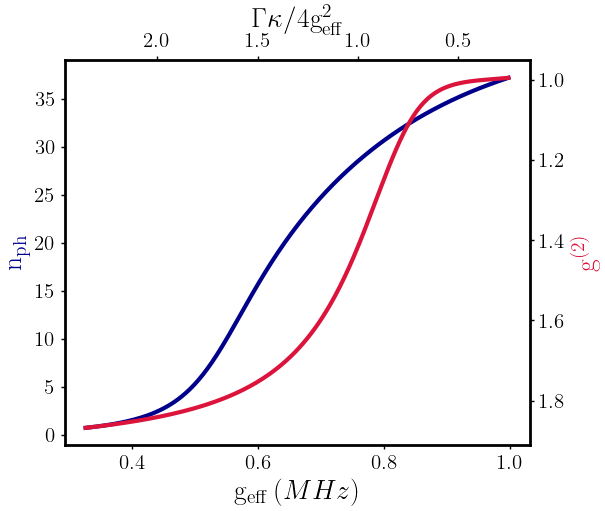

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)

ax1.plot(geff_arr*1e3, avg_ph_arr,c='darkblue',lw=3)
ax1.set_xlabel(r'$\mathrm{g_{eff}} \, (MHz)$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{n_{ph}}$', fontsize=20,c='darkblue')
ax1.tick_params(axis='x', labelsize=15) 
ax1.tick_params(axis='y', labelsize=15) 

ax2.plot(Gamma*kappa/(4*geff_arr**2), g2_arr,c='crimson',lw=3)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$\mathrm{\Gamma \kappa / 4 g_{eff}^2}$', fontsize=20)
ax2.set_ylabel(r'$\mathrm{g^{(2)}}$', fontsize=20,c='crimson')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', labelsize=15)  
ax2.tick_params(axis='y', labelsize=15) 
ax2.invert_xaxis()
ax2.invert_yaxis()
plt.show()

# System engineering

In order to engineer this system we refer to the following tunable coupler schematic:

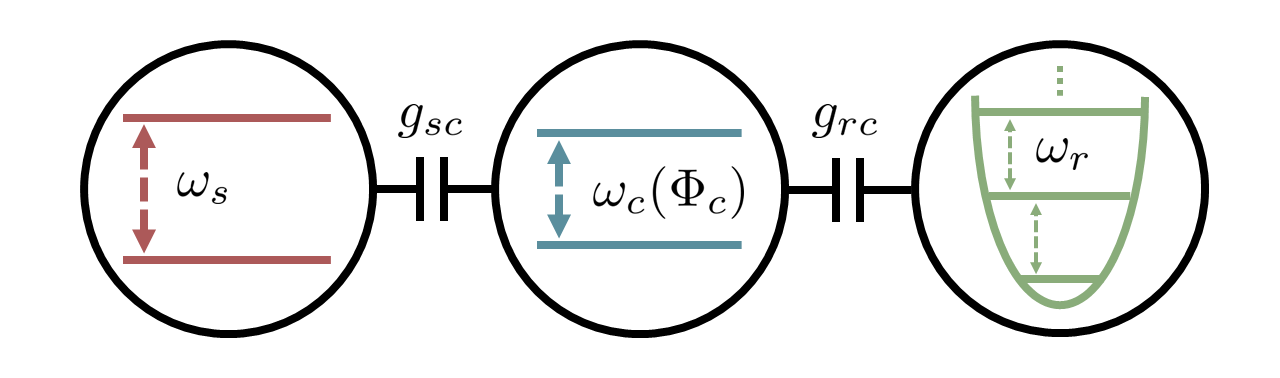

The system is defined by a two level system in the masing regime, representing the photon source, with a transition frequency $\omega_s$, a cavity of resonance frequency $\omega_r = \omega_s$ and a qubit in between with a transition frequency $\omega_c(\Phi_c)$ which can be tuned through the external flux $\Phi_c$. We engineer the system so that the photon source and the cavity are both dispersively coupled to the central tunable qubit $(g_{ic}/(\omega_i - \omega_c) << 1 , i =s,r)$. Under this hypothesis we can apply a Schrieffer-Wolff transformation that allows to pass from the original three body scheme to a two body system with the masing qubit and the cavity that are coupled  with a coupling strength $g_{eff}$ that depends on the transition frequency of the coupler and thus on the external flux $\Phi_c$.
Considering the relations between the effective coupling and the electrodynamic parameters of the setup:

$g_{eff} = \frac{1}{2}g_{sc}g_{rc}\left(\frac{1}{\Delta_{sc}} + \frac{1}{\Delta_{rc}}\right) + g_{sr}$

where:

$g_{sc} = \frac{C_{sc}}{\sqrt{C_s C_c}}\sqrt{\omega_s \omega_c}$

$g_{rc} = \frac{C_{rc}}{\sqrt{C_r C_c}}\sqrt{\omega_r \omega_c}$

$g_{sr} = \frac{C_{sr}}{\sqrt{C_s C_r}}\sqrt{\omega_s \omega_r} + \frac{C_{sc}C_{rc}}{\sqrt{C_s C_r C_c^2}}\sqrt{\omega_s \omega_r}$

where $C_{ij} \, (i,j = s,c,r)$ are the coupling capacities between the element $i$ and the element $j$, while $C_i \, (i=s,c,r)$ are the self-capacities of the element $i$ to GND.
We can engineer the system to have a range of values for the effective coupling strength that allows to span the number of photons that can be injected in the cavity between two distinct values 

## Tunable coupler

To be able to have a fine control over the effective coupling strength values without worrying about exiting the dispersive coupling approximation, we can engineer the tunable coupler to have a zero-flux transition frequency which is lower than the masing qubit and the reservoir. Additionally, we can tune the available range of values for the coupling strength also by adding an asymmetry to the SQUID characterizing the tunable coupler 

In [7]:
### !C: (F), I: (A)!
### flux in units of flux quanta

phi = np.linspace(0.,0.5,501)

### tunable coupler

Ic1 = 60e-9 # JJ critical current
Ctc = 275e-15 # self capacity to GND
d = 0.05 # asymmetry ratio

In [8]:
### tunable coupler Josephson energy

def Ej(p,Ic1=Ic1,d=d):
    
    Ic2 = Ic1 * (1+d)/(1-d)
    
    Ej1 = phi0 * Ic1 / (2 * np.pi)
    Ej2 = phi0 * Ic2 / (2 * np.pi)
    
    return (Ej1 + Ej2)*np.sqrt(np.cos(np.pi*p)**2 + d**2 * np.sin(np.pi*p)**2) * 0.5

### tunable coupler transition frequency

def omega_tc(p,Ic1=Ic1,d=d,C=Ctc):
    
    Ec = e**2 / (2 * C)
    
    return (-Ec + np.sqrt(8*Ec*Ej(p,Ic1=Ic1,d=d)))/hbar*1e-9

(array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 [Text(0, 0.5, '$\\mathdefault{0.5}$'),
  Text(0, 1.0, '$\\mathdefault{1.0}$'),
  Text(0, 1.5, '$\\mathdefault{1.5}$'),
  Text(0, 2.0, '$\\mathdefault{2.0}$'),
  Text(0, 2.5, '$\\mathdefault{2.5}$'),
  Text(0, 3.0, '$\\mathdefault{3.0}$'),
  Text(0, 3.5, '$\\mathdefault{3.5}$'),
  Text(0, 4.0, '$\\mathdefault{4.0}$'),
  Text(0, 4.5, '$\\mathdefault{4.5}$')])

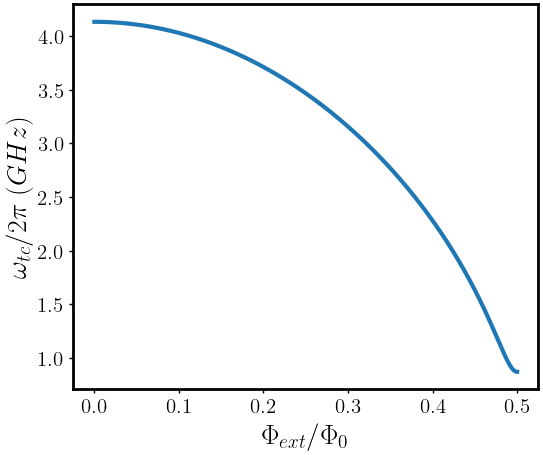

In [23]:
### tunable coupler frequency plot

plt.figure()
plt.plot(phi,omega_tc(phi)/(2*np.pi),lw=3)
plt.xlabel(r'$\Phi_{ext}/\Phi_0$',fontsize=20)
plt.ylabel(r'$\omega_{tc}/2\pi$ $(GHz)$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Coupling engineering

In [10]:
### photon source

Cs = 100e-15 # self capacity to GND
C_stc = 1e-15 # coupling capacity to the tunable coupler
omegas = 5 * 2 * np.pi # resonance frequency

### cavity

Cr = 400e-15 # self capacity to GND
C_rtc = 1e-15 # coupling capacity to the tunable coupler
omegar = omegas # resonance frequency

### photon source - cavity

C_sr = 0. # direct coupling capacitance between the photon source and the cavity

### coupling dictionary

def g_dict(phi,
          o_s = omegas,
          o_r = omegar,
          Cs = Cs,
          Cc = Ctc,
          Cr = Cr,
          C_sr = C_sr,
          C_rc = C_rtc,
          C_sc = C_stc):
    
    o_tc = omega_tc(phi)
    
    delta_sc = o_s - o_tc
    delta_rc = o_r - o_tc
    
    g = {}
    
    g['sc'] = 0.5 * C_sc / (np.sqrt(Cs * Cc)) * np.sqrt(o_s*o_tc)

    g['rc'] = 0.5 * C_rc / (np.sqrt(Cr * Cc)) * np.sqrt(o_r*o_tc)

    g_sr_d = 0.5 * C_sr / (np.sqrt(Cs * Cr)) * np.sqrt(o_s*o_r) 

    g_sr_i =  0.5 * C_sc * C_rc / (np.sqrt(Cs * Cc**2 * Cr)) * np.sqrt(o_s*o_r)

    g['sr'] = g_sr_d + g_sr_i
    
    g['eff'] = 0.5 * g['sc'] * g['rc'] * ( 1 / delta_sc + 1 / delta_rc) + g['sr']
    
    return g

With the goal of replicating the behaviour of the system in the previous chapter, we sweep on the capacitive couplings $C_{sc}, C_{rc}$

We want to engineer the effective coupling of the system between two well defined values corresponding to the maximum and the minimum number of steadystate photons that we want to inject inside the resonator. To do that we choose two parameters inside the $g_{eff}$ formula to be the indipendent variables, while keeping all the other parameters fixed. We choose the minimum number of photons $n_{ph}^{min}$ and the maximum number of photons $n_{ph}^{max}$ we want to work with. These two values will correspond to the following maximum and minimum values for the effective coupling:

$g_{eff}^{min} = \frac{1}{2} \sqrt{\frac{\Gamma \kappa}{1 - n_{ph}^{max}/n_{max}}}$

$g_{eff}^{max} = \frac{1}{2} \sqrt{\frac{\Gamma \kappa}{1 - n_{ph}^{min}/n_{max}}}$

We thus optimize the coupling shape by sweeping on these two indipendent variables and evaluating how distant we are from the desired maximum and minimum values.

In [11]:
### number of photons -> effective coupling
def g_range(n_min,n_max):
    
    max_n_ph = Gamma/(2*kappa)
    g_min = 0.5 * np.sqrt( Gamma * kappa / ( 1 - n_max/max_n_ph))
    g_max = 0.5 * np.sqrt( Gamma * kappa / ( 1 - n_min/max_n_ph))
    
    return g_min,g_max

In [12]:
n_min = 0 # minimum number of steady-state photons in the tunable range
n_max = 40 # maximum number of steady-state photons in the tunable range

g_min,g_max = g_range(n_min,n_max)

## Double sweep

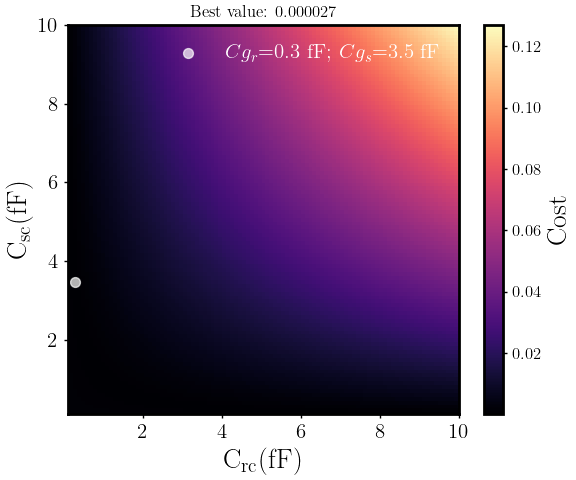

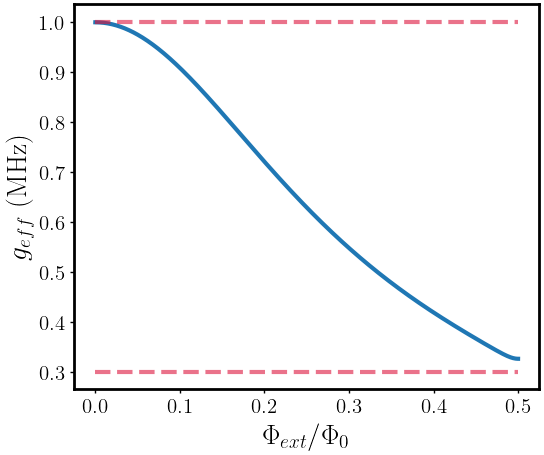

In [24]:
# sweep range
C_rtc_arr = np.linspace(0.1,10,101)*1e-15
C_stc_arr = np.linspace(0.1,10,101)*1e-15

# cost function initialization
cost = []

for C_rtc in C_rtc_arr:
    for C_stc in C_stc_arr:
        
        geff_max = g_dict(0,
                         C_rc=C_rtc,
                         C_sc=C_stc)['eff']
        geff_min = g_dict(0.5,
                         C_rc=C_rtc,
                         C_sc=C_stc)['eff']
        
        # ratio between the obtained and desired value
        dist_max = np.abs(geff_max-g_max)
        dist_min = np.abs(geff_min-g_min)
        cost_val = dist_max + dist_min
        
        # cost function to evaluate the distance from the ideal case
        cost.append(cost_val)
        
cost_f = np.array(cost).reshape((len(C_rtc_arr),len(C_stc_arr)))

### map of the cost function
plt.figure()
plt.pcolormesh((C_rtc_arr)*1e15,(C_stc_arr)*1e15,cost_f.transpose(),cmap='magma')
cbar = plt.colorbar()
best_indxs = np.unravel_index(cost_f.argmin(), cost_f.shape)
best_Crtc = C_rtc_arr[best_indxs[0]]
best_Cstc = C_stc_arr[best_indxs[1]]
plt.scatter(best_Crtc*1e15,best_Cstc*1e15,s=50,c='white',alpha=0.7,
            label=fr'$Cg_r$={best_Crtc*1e15:.1f} fF; $Cg_s$={best_Cstc*1e15:.1f} fF' )
cbar.ax.set_ylabel(r'$\mathrm{Cost}$',fontsize=20)
plt.xlabel(r'$\mathrm{C_{rc} (fF) } $',fontsize=20)
plt.ylabel(r'$\mathrm{C_{sc} (fF) } $',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15) 
plt.legend(fontsize=15,labelcolor='w',framealpha=0)
plt.title(f'Best value: {cost_f[best_indxs]:4f}')
plt.tight_layout()
plt.xlim(min(C_rtc_arr)*1e15,max(C_rtc_arr)*1e15)
plt.ylim(min(C_stc_arr)*1e15,max(C_stc_arr)*1e15)


### best value display
g = g_dict(phi,
          C_rc=best_Crtc,
          C_sc=best_Cstc)

plt.figure()
plt.plot(phi,g['eff']*1e3,lw=3)
plt.xlabel(r'$\Phi_{ext}/\Phi_0$',fontsize=20)
plt.ylabel(r'$g_{eff}$ (MHz)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hlines(y=g_max*1e3,xmin=min(phi),xmax=max(phi),lw=3,ls='--',color='crimson',
           alpha=0.6)
plt.hlines(y=g_min*1e3,xmin=min(phi),xmax=max(phi),lw=3,ls='--',color='crimson',
           alpha=0.6)

## Single sweep

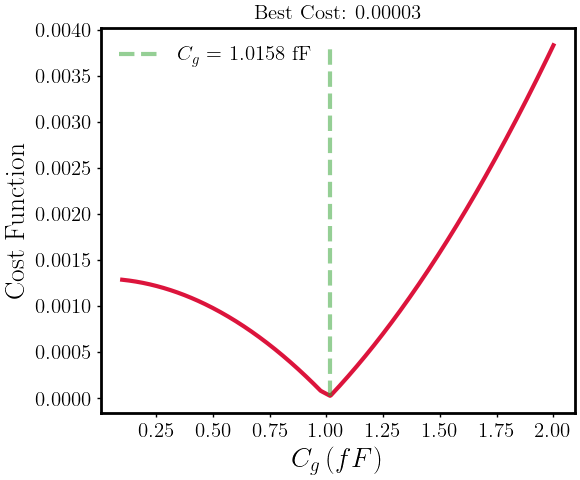

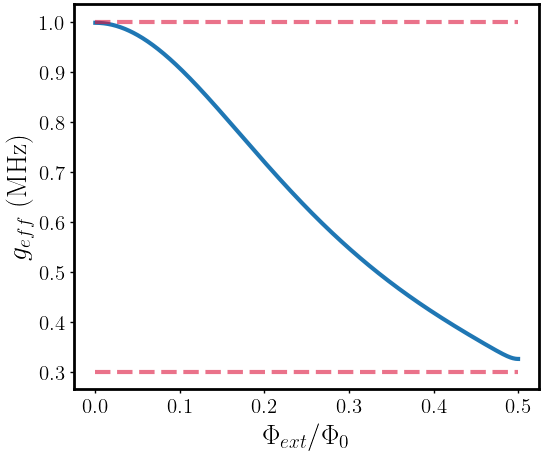

In [25]:
# coupling sweep
CgArray = np.linspace(0.1,2,501)*1e-15

# cost function initialization
cost = []

for Cg in CgArray:
        
        geff_max = g_dict(0,
                         C_rc=Cg,
                         C_sc=Cg)['eff']
        geff_min = g_dict(0.5,
                         C_rc=Cg,
                         C_sc=Cg)['eff']
        
        # ratio between the obtained and desired value
        
        dist_max = np.abs(geff_max-g_max)
        dist_min = np.abs(geff_min-g_min)
        cost_val = dist_max + dist_min
        
        # cost function to evaluate the distance from the ideal case
        cost.append(cost_val)
        
cost_f = np.array(cost)

plt.figure()
plt.plot((CgArray)*1e15,cost_f,lw=3,c='crimson')
min_ind = np.argmin(cost_f)
best_Cg = CgArray[min_ind]
plt.vlines(best_Cg*1e15,ymin=min(cost_f),ymax=max(cost_f),lw=3,ls='--',color='tab:green',
           alpha=0.5,label=fr'$C_g$ = {best_Cg*1e15} fF')
plt.title(f'Best Cost: {cost_f[min_ind]:.5f}',fontsize=15)
plt.xlabel(r'$C_{g} \, (fF)  $',fontsize=20)
plt.ylabel(r'Cost Function',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15) 
plt.legend(fontsize=15,framealpha=0.)
plt.tight_layout()


g = g_dict(phi,
          C_rc=best_Cg,
          C_sc=best_Cg)

plt.figure()
plt.plot(phi,g['eff']*1e3,lw=3)
plt.xlabel(r'$\Phi_{ext}/\Phi_0$',fontsize=20)
plt.ylabel(r'$g_{eff}$ (MHz)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hlines(y=g_max*1e3,xmin=min(phi),xmax=max(phi),lw=3,ls='--',color='crimson',
           alpha=0.6)
plt.hlines(y=g_min*1e3,xmin=min(phi),xmax=max(phi),lw=3,ls='--',color='crimson',
           alpha=0.6)

The behaviour of the system after the optimization:

In [16]:
geff_arr = g_dict(phi, 
                  C_rc=best_Cg,
                  C_sc=best_Cg)['eff']

steadystate_res = [steadystate_vals(x) for x in geff_arr]
avg_ph_arr, g2_arr = map(np.array, zip(*steadystate_res))

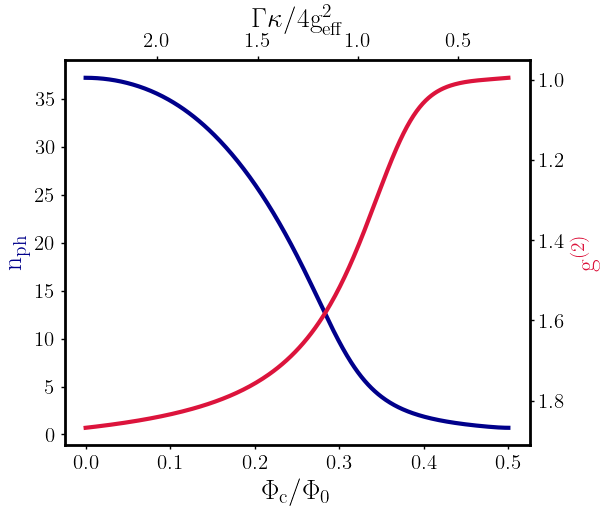

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)

ax1.plot(phi, avg_ph_arr,c='darkblue',lw=3)
ax1.set_xlabel(r'$\mathrm{\Phi_c/\Phi_0}$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{n_{ph}}$', fontsize=20,c='darkblue')
ax1.tick_params(axis='x', labelsize=15) 
ax1.tick_params(axis='y', labelsize=15) 

ax2.plot(Gamma*kappa/(4*geff_arr**2), g2_arr,c='crimson',lw=3)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$\mathrm{\Gamma \kappa / 4 g_{eff}^2}$', fontsize=20)
ax2.set_ylabel(r'$\mathrm{g^{(2)}}$', fontsize=20,c='crimson')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', labelsize=15)  
ax2.tick_params(axis='y', labelsize=15) 
ax2.invert_xaxis()
ax2.invert_yaxis()
plt.show()

After engineering the system according to the wanted range of photons we want to work with, we are interested in understanding the robustness of the system towards undesired variation of $\Gamma$ , $\kappa$ and of the capacitance underplay. To evaluate the robustness of the system in this undesired situations we analyze the variation of the second order correlation function $g^{(2)}$ over the whole flux range and we evaluate how much the variation changes as well as the range of photons.

In [30]:
Gamma_arr = np.linspace(Gamma*0.1,Gamma*1.9,51) 
kappa_arr = np.linspace(kappa*0.1,kappa*1.9,51) 
g_range = g_dict(np.array([0,0.5]),
          C_rc=best_Cg,
          C_sc=best_Cg)['eff']

workmap_list = []
n_range_list = []

for kappa_val in (kappa_arr):
    for Gamma_val in (Gamma_arr):
        
        steadystate_res = [steadystate_vals(x,kappa=kappa_val,Gamma=Gamma_val) for x in g_range]
        avg_ph_arr, g2_arr = map(np.array, zip(*steadystate_res))
        workmap_list.append(abs(np.diff(g2_arr)[0]))  
        n_range_list.append(abs(np.diff(avg_ph_arr)[0]))

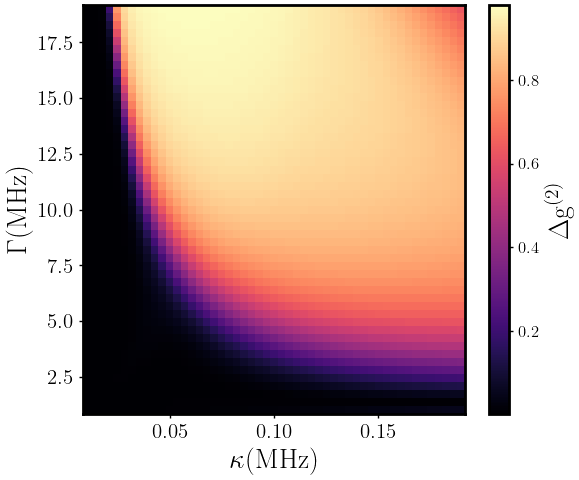

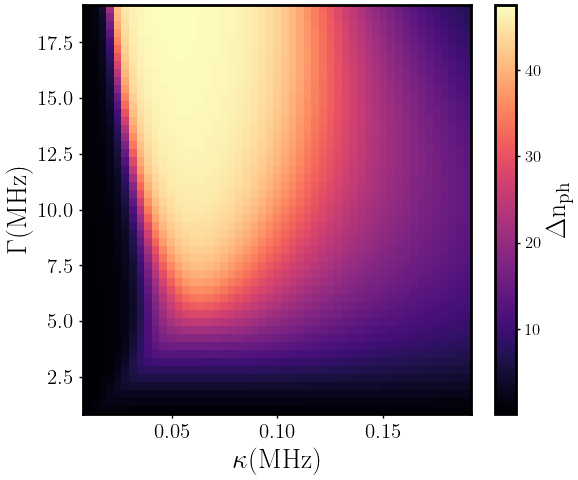

In [31]:
plt.figure()
workmap = np.array(workmap_list).reshape((len(kappa_arr),len(Gamma_arr)))
plt.pcolormesh((kappa_arr)*1e3,(Gamma_arr)*1e3,workmap.transpose(),cmap='magma')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\mathrm{\Delta g^{(2)}}$',fontsize=20)
plt.xlabel(r'$\mathrm{\kappa (MHz) } $',fontsize=20)
plt.ylabel(r'$\mathrm{\Gamma (MHz) } $',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15) 
plt.legend(fontsize=15,labelcolor='w',framealpha=0)
plt.tight_layout()

plt.figure()
nrange_map = np.array(n_range_list).reshape((len(kappa_arr),len(Gamma_arr)))
plt.pcolormesh((kappa_arr)*1e3,(Gamma_arr)*1e3,nrange_map.transpose(),cmap='magma')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\mathrm{\Delta n_{ph}}$',fontsize=20)
plt.xlabel(r'$\mathrm{\kappa (MHz) } $',fontsize=20)
plt.ylabel(r'$\mathrm{\Gamma (MHz) } $',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15) 
plt.legend(fontsize=15,labelcolor='w',framealpha=0)
plt.tight_layout()

# Multiple cavities

Here we explore the case where also the photon source present tunability. This allows to expand the fan out of the system to multiple cavities characterized by different resonance frequency and to populate them individually.

In this situation we analyse tha required variation over the coupling capacities $g_{cr_{n}}$ for different resonance frequencies of the cavity.

After that we study the cross-population between two cavities for different electrodynamic parameters of the system and in which situation this phenomena is mitigated

provare anche a fare uno studio del detuning in termini di diversi $\kappa$ dei risonatori

## Coupling curve

The control over the injected number of photons in the proposed setup is strongly correlated to the control over the effective coupling between the photon source and the target cavity. In the presence of multiple cavities characterized by different resonance frequencies and self capacity to ground the coupling capacity between the coupler and the cavity must be changed accordingly to obtain the same $g_{eff}(\Phi_c)$ curve.
To perform this analysis we take as reference the single cavity case considered before. We thus change the resonance frequency of the single resonator while keeping all the other parameters fixed, which ultimately returns a different $g_{eff}(\Phi_c)$ curve.
Consider as a reference the following expression of the effective coupling for the photon source and the cavity being perfectly on resonance:

$g_{eff}(\Phi_c) = \frac{g_{sc}g_{rc}}{\omega_r - \omega_c}$ 

where we have neglected the indirect coupling term between the photon source and the cavity and assumed that $\omega_s = \omega_r$.
A variation of the cavity frequency will lead to a variation of both the frequency $\omega_r' = \omega_r + \Delta$ and the self capacity to ground of the resonator $C_r' = \beta C_r$, leading to a different coupling curve:

$g_{eff}'(\Phi_c) = \frac{g_{sc}g_{rc}'}{\omega_r' - \omega_c}$ 

This variation leads to a simple renormalization of the $g_{rc}$:

$g_{rc}' = \frac{C_{rc}}{\sqrt{C_c C_r'}} \sqrt{\omega_r' \omega_c} = \frac{C_{rc}}{\sqrt{C_c \beta C_r}} \sqrt{(\omega_r + \Delta) \omega_c}$

We can rewrite this expression in terms of $g_{rc}$ in the following way:

$g_{rc}'  = \frac{1}{\sqrt{\beta}} \left( \frac{C_{rc}}{\sqrt{C_c C_r}} \sqrt{\omega_r \omega_c} + \frac{C_{rc}}{\sqrt{C_c C_r}} \sqrt{\Delta \omega_c} \right) = \frac{1}{\sqrt{\beta}} g_{rc} \left(1 + \sqrt{\frac{\Delta}{\omega_r}} \right) = \alpha g_{rc}$ 

where the constant of proportionality is $\alpha = \frac{1}{\sqrt{\beta}} \left( 1 + \sqrt{\frac{\Delta}{\omega_r}} \right)$. We ask ourselves if we can renormalize the coupling capacity $C_{rc}' = \zeta C_{rc}$ in a way that keeps the coupling curve unmodified under a frequency change of the resonator:

$g_{eff}' = g_{eff} \leftrightarrow \alpha \zeta \frac{g_{sc}g_{rc}}{\omega_r - \omega_c + \Delta} = \frac{g_{sc}g_{rc}}{\omega_r - \omega_c}$ 

This leads to the following definition of the coupling renormalization factor $\zeta$:

$\zeta = \frac{1}{\alpha}\left(1 + \frac{\Delta}{\omega_r - \omega_c} \right) $

We can thus always find an ideal coupling capacity that returns the same coupling curve for any resonator on the fan-out of the system inside the frequency range of the photon source

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(-0.5, 0, '$\\mathdefault{−0.5}$'),
  Text(0.0, 0, '$\\mathdefault{0.0}$'),
  Text(0.5, 0, '$\\mathdefault{0.5}$'),
  Text(1.0, 0, '$\\mathdefault{1.0}$'),
  Text(1.5, 0, '$\\mathdefault{1.5}$'),
  Text(2.0, 0, '$\\mathdefault{2.0}$'),
  Text(2.5, 0, '$\\mathdefault{2.5}$')])

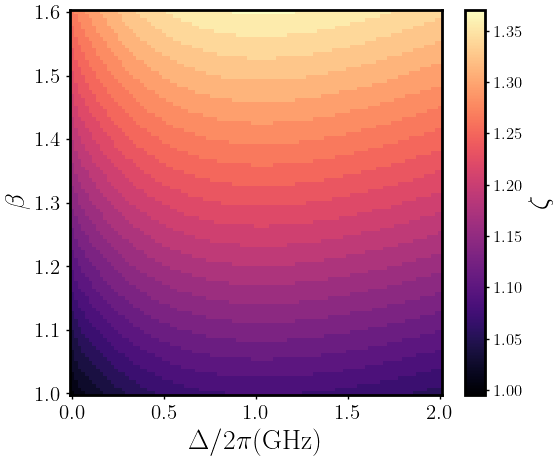

In [34]:
### sweep params
delta_arr = np.linspace(0,2,101) * 2 * np.pi 
beta_arr = np.linspace(1,1.6,101)
zeta_arr = np.linspace(0.5,2,101)

geff_ref = g_dict(phi,
          C_rc=best_Cg,
          C_sc=best_Cg,
          o_r = omegar)['eff']


best_zeta = []
for delta_val in delta_arr:
    for beta_val in beta_arr:
        dist = []
        for zeta_val in zeta_arr:
            geff_targ = g_dict(phi,
                                 C_rc = zeta_val*best_Cg,
                                 C_sc=best_Cg,
                                 Cr = beta_val*Cr,
                                 o_r=(omegar + delta_val))['eff']
        
            max_g = np.max((geff_ref,geff_targ))
        
            geff_targ_tuple = np.array([(f,g) for f,g in zip(phi,geff_targ/max_g)])
            geff_ref_tuple = np.array([(f,g) for f,g in zip(phi,geff_ref/max_g)])
        
            dist.append(distance.directed_hausdorff(geff_targ_tuple, geff_ref_tuple)[0])
            
        best_zeta.append(zeta_arr[np.argmin(dist)])

plt.figure()
best_zeta_map = np.array(best_zeta).reshape((len(delta_arr),len(beta_arr)))
plt.pcolormesh(delta_arr/(2*np.pi),beta_arr,best_zeta_map.transpose(),cmap='magma')
ticks=np.linspace(0.,1,3)
cbar=plt.colorbar()
cbar.ax.set_ylabel(r'$\mathrm{\zeta}$',fontsize=20)
plt.xlabel(r'$\mathrm{\Delta / 2 \pi (GHz)} $',fontsize=20)
plt.ylabel(r'$\mathrm{\beta} $',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15) 

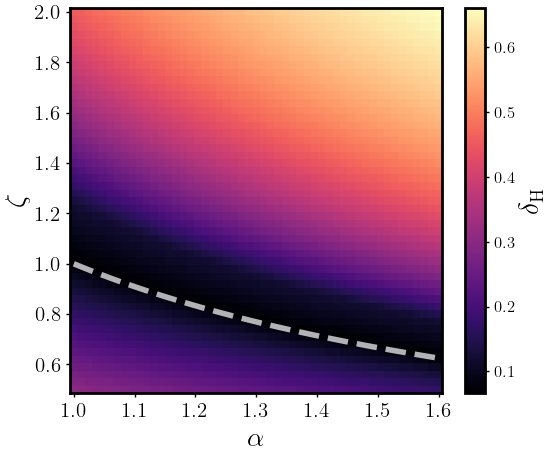

In [35]:
### sweep params
delta_val = 3 * 2 * np.pi 
alfa_arr = np.linspace(1,1.6,51)
zeta_arr = np.linspace(0.5,2,51)

geff_ref = g_dict(phi,
          C_rc=best_Cg,
          C_sc=best_Cg,
          o_r = omegar)['eff']


dist = []
for alfa_val in alfa_arr:
    for zeta_val in zeta_arr:
        
        geff_targ = g_dict(phi,
                             C_rc = alfa_val*zeta_val*best_Cg,
                             C_sc=best_Cg,
                             o_r=(omegar + delta_val))['eff']

        max_g = np.max((geff_ref,geff_targ))

        geff_targ_tuple = np.array([(f,g) for f,g in zip(phi,geff_targ/max_g)])
        geff_ref_tuple = np.array([(f,g) for f,g in zip(phi,geff_ref/max_g)])

        dist.append(distance.directed_hausdorff(geff_targ_tuple, geff_ref_tuple)[0])


plt.figure()
dist_map = np.array(dist).reshape((len(alfa_arr),len(zeta_arr)))
plt.pcolormesh(alfa_arr,zeta_arr,dist_map.transpose(),cmap='magma')


ticks=np.linspace(0.,1,3)
cbar=plt.colorbar()
cbar.ax.set_ylabel(r'$\mathrm{\delta_H}$',fontsize=20)


plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$\zeta$',fontsize=20) 
plt.yticks(fontsize=15)
plt.xticks(fontsize=15) 
plt.plot(alfa_arr,1/alfa_arr,lw=4,ls='--',c='w',alpha=0.7)